
This script provides visualization utilities for image segmentation tasks using matplotlib and numpy.
Main functionalities include:
- show_mask: Overlays a mask on a matplotlib axis, with the option to use a random color.
- show_points: Displays positive and negative sample points (e.g., for interactive segmentation), with green for positive and red for negative points.
- show_box: Visualizes bounding boxes with a blue outline.
- show_anns: Renders a list of segmentation annotations, sorted by area, each with a different color—useful for multi-instance segmentation.

These visualization tools are helpful for analyzing, debugging, and presenting results from deep learning segmentation models.

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import os

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white',
               linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white',
               linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor="#839DD6", facecolor=(0, 0, 0, 0), lw=3))
    
    
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)


data_cls = ['Intestine', 'brain', 'colon', 'PDAC']
data_name = data_cls[3]

This code defines a list of class names and assigns the fourth element ('PDAC') to the variable data_name.


In [2]:
data_cls=['Intestine','brain','colon','PDAC']
data_name=data_cls[3]

In [3]:
"""
1. Initialize the model:
   - Import necessary modules, including warnings and torch.
   - Suppress warnings for cleaner output.
   - Import the ORGDET class from orgline.
   - Load the model using the specified YAML configuration file.
   - Define the path to the training dataset YAML, which is based on the selected data_name variable.
"""

# 1. Initialize model
import warnings
import torch
warnings.filterwarnings('ignore')
from orgline import ORGDET
model = ORGDET(r'orgline/cfg/models/our_model/orgline.yaml') # select your model.pt path
train_path = r'data/' + data_name + '.yaml'

WARNING  no model scale passed. Assuming scale='n'.

                   from  n    params  module                                       arguments                     
  0                  -1  1 230249048  hiera3                                       []                            
  1                  -1  1   2624512  orgline.nn.modules.block.SPPF                [1024, 1024, 5]               
  2                   1  1     16640  orgline.nn.modules.conv.Conv                 [128, 128, 1, 1]              
  3                   2  1     66048  orgline.nn.modules.conv.Conv                 [256, 256, 1, 1]              
  4                   3  1    263168  orgline.nn.modules.conv.Conv                 [512, 512, 1, 1]              
  5                   5  1   1050624  orgline.nn.modules.conv.Conv                 [1024, 1024, 1, 1]            
  6        [6, 7, 8, 9]  1   6508769  orgline.nn.extra_modules.head.Detect_AFPN_P2345_Custom[3, 256, 'RepConv', [128, 256, 512, 1024]]
orgline summar

In [ ]:
from orgline.build_model import load_sam2_pretrained
predictor = load_sam2_pretrained(
    model_name="hiera_large",                 # Choose the model size/variant, e.g., "hiera_large"
    config_dir=r'orgline/sam2_configs',
    download_dir='./'# Path to the directory with config files
)

In [4]:

"""
2. Merge and load model weights:
   - Import the merge_and_load_model_weights function.
   - Call the function to merge lightweight and SAM2 weights into the model.
   - Save the merged weights to the specified path.
   - Check if loading was successful and print the result.
   - (Optional) Use the loaded_model for inference.
"""

from orgline.weights_merge import merge_and_load_model_weights
# 2. Call weight merging function
loaded_model = merge_and_load_model_weights(
    model=model,
    lightweight_path='orgdet.pt',          # Path to lightweight weights
    sam_path='sam2_hiera_large.pt',        # Path to SAM2 weights
    verbose=True,
    save_path='weights/orgdet_complete_merged.pt'# Whether to show detailed info
)

# 3. Check loading result
if loaded_model is not None:
    print("✅ Model weights loaded successfully!")

    # Now you can use the model for inference
    # results = loaded_model('image.jpg')

else:
    print("❌ Model weight loading failed!")

=== Checking Required Files ===
✅ orgdet.pt - 55.0 MB
✅ sam2_hiera_large.pt - 856.4 MB

=== Loading and Merging Weights ===
1. Loading lightweight checkpoint...
✅ Lightweight weights loaded successfully
Checkpoint keys: ['epoch', 'best_fitness', 'ema', 'updates', 'optimizer', 'train_args', 'train_metrics', 'train_results', 'date', 'version', 'lightweight_state_dict', 'is_lightweight', 'sam_source_file']

2. Loading SAM2 weights...
✅ SAM2 weights loaded successfully
SAM2 weight count: 900

3. Merging weights...
Lightweight weight count: 873
Transferred 586 weights from SAM2
Total weight count after merge: 1459

=== Safely Loading Weights to Model (strict=False) ===
Underlying model type: <class 'orgline.nn.tasks.DetectionModel'>
Model parameter count: 1459
Weight parameter count: 1459
Missing parameters: 0
Unexpected parameters: 0
✅ Weights loaded successfully

=== Saving Complete Checkpoint to weights/orgdet_complete_merged.pt ===
✅ Complete checkpoint saved to: weights/orgdet_complete

In [5]:
"""
3. Run model predictions and collect results:
   - Suppress warnings for cleaner output.
   - Construct the root path to the training images based on data_name.
   - Run the model's predict method on the specified image directory, saving results and prediction details.
   - Collect the output as a dictionary mapping image paths to their corresponding detected bounding boxes.
"""

import warnings
warnings.filterwarnings('ignore')
root_path = r'datasets' + '/' + data_name + '/' + r'train/images'
print(root_path)
out = model.predict(
    source=root_path,
    project='runs',
    name='exp',
    save=True,
    visualize=False,  # visualize model feature maps
    save_conf=True,
    save_txt=True,
    conf=0.2,
    iou=0.7
)
out_dict = {outimg.path: outimg.boxes.xyxy for outimg in out}

datasets\PDAC\train\images



image 1/3 d:\OrgLine\datasets\PDAC\train\images\1.png: 640x640 76 0s, 33.7ms
image 2/3 d:\OrgLine\datasets\PDAC\train\images\32.png: 640x640 12 0s, 33.4ms
image 3/3 d:\OrgLine\datasets\PDAC\train\images\Human_1_004h_patch_0.tif: 640x640 26 0s, 56.9ms
Speed: 2.7ms preprocess, 41.3ms inference, 47.2ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\exp23
3 labels saved to runs\exp23\labels


In [6]:
"""
4. Extract image paths from the prediction results:
   - Create a list of image file paths by retrieving the keys from out_dict.
"""

img_path = list(out_dict.keys())

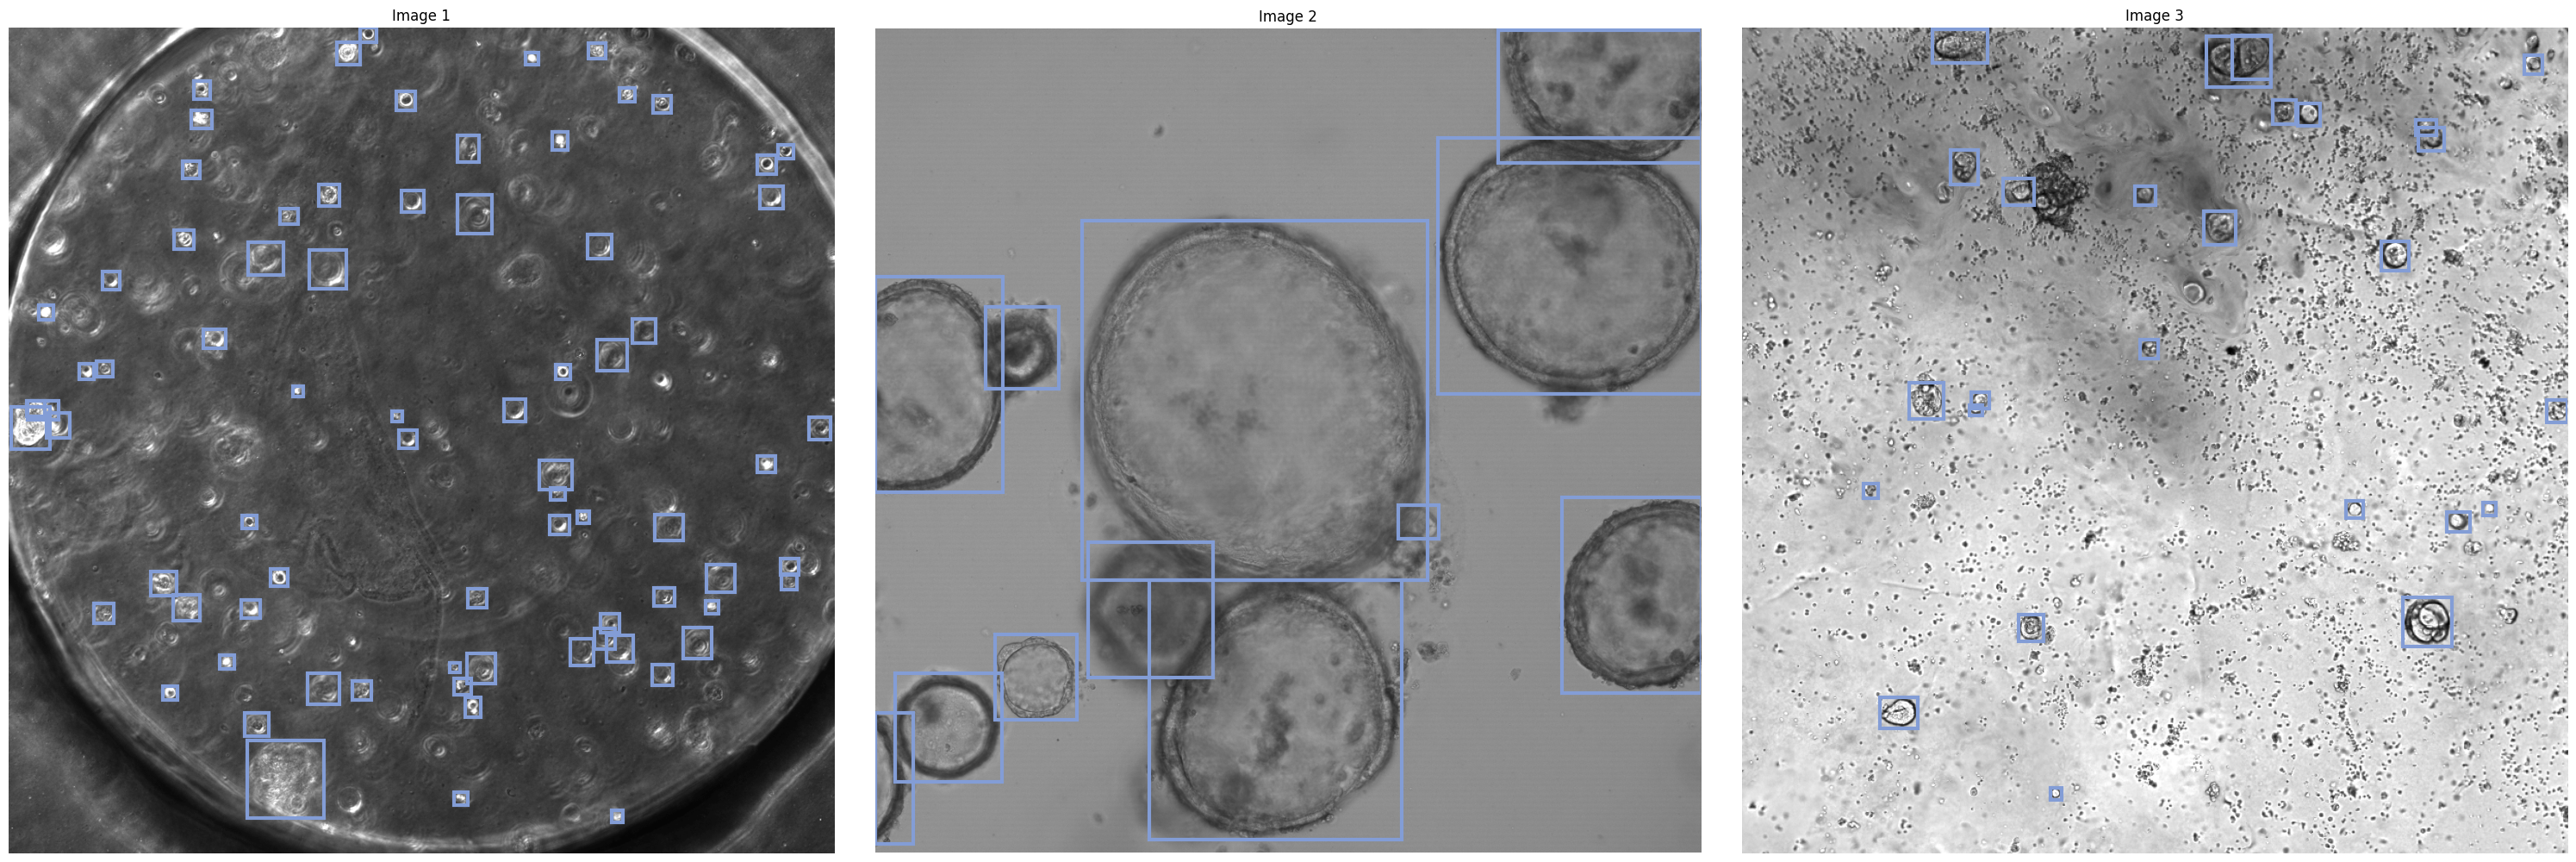

In [7]:
"""
5. Visualize detection results for the first three images:
   - Set up matplotlib for plotting.
   - For each of the first three images:
       - Read the image using OpenCV and convert BGR to RGB.
       - Retrieve bounding boxes from the prediction results and stack them as tensors.
       - Display each image in a subplot and draw the corresponding bounding boxes.
   - Adjust subplot layout and show the final visualization.
"""

import torch
device = "cuda"
import cv2
import matplotlib.pyplot as plt

# Create horizontal subplot layout
fig, axes = plt.subplots(1, 3, figsize=(30, 10))  # 1 row, 3 columns

for idx, image_file in enumerate(img_path[:3]):  # Test only first 3 images
    # Read image using cv2
    img = cv2.imread(image_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    input_boxes = []
    
    for line in out_dict.get(image_file):
        # Parse each line of label data
        label_data = line
        input_boxes.append(torch.tensor(label_data, device=device))
    
    input_boxes = torch.stack(input_boxes, dim=0)
    
    # Display image on corresponding subplot
    axes[idx].imshow(img)
    for box in input_boxes:
        show_box(box.cpu().numpy(), axes[idx])
    
    axes[idx].axis('off')
    axes[idx].set_title(f'Image {idx+1}')  # Optional: add title

# Adjust spacing between subplots
plt.tight_layout()
plt.subplots_adjust(wspace=0.05)  # Adjust horizontal spacing between subplots

plt.show()

In [8]:
# Load a SAM2 predictor with pre-trained weights.
# 
# Arguments:
#   model_name:    The specific model variant to use (e.g., "hiera_large").
#   config_dir:    The directory containing configuration files for SAM2.
# 
# Returns:
#   predictor:     An initialized predictor object ready for inference or fine-tuning.
from orgline.build_model import load_sam2_pretrained
predictor = load_sam2_pretrained(
    model_name="hiera_large",                 # Choose the model size/variant, e.g., "hiera_large"
    config_dir=r'orgline/sam2_configs',
    download_dir='./'# Path to the directory with config files
)

Weight file size: 856.35 MB
Weight file sam2_hiera_large.pt already exists and verified
Loading model...
Model loaded successfully!


In [9]:
"""
7. Generate segmentation masks for each image using the SAM2 predictor:
   - Iterate over all image paths.
   - For each image:
       - Read and convert the image to RGB.
       - Retrieve and stack the corresponding bounding boxes from the detection results.
       - Use the SAM2 predictor to generate segmentation masks for the detected boxes, with no additional points.
       - Store the resulting masks in a dictionary keyed by image file path.
       - Print progress information and clear CUDA cache to free memory.
"""

out_mask = {}
for image_file in img_path[:]: 
    img = cv2.imread(image_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    input_boxes = []
    for line in out_dict.get(image_file):
        label_data = np.array(line.cpu())
        input_boxes.append(label_data)
    input_boxes = np.stack(input_boxes, axis=0)
    with torch.no_grad():
        predictor.set_image(img)
        transformed_boxes = input_boxes
        masks, _, _ = predictor.predict(
            point_coords=None,
            point_labels=None,
            box=transformed_boxes,
            multimask_output=False,
        )
        outmask = masks
        out_mask[image_file] = outmask
        print(f"{image_file} predict done!")
        torch.cuda.empty_cache()

d:\OrgLine\datasets\PDAC\train\images\1.png predict done!
d:\OrgLine\datasets\PDAC\train\images\32.png predict done!
d:\OrgLine\datasets\PDAC\train\images\Human_1_004h_patch_0.tif predict done!


In [10]:
out_mask['d:\\OrgLine\\datasets\\PDAC\\train\\images\\1.png'].shape

(76, 1, 1024, 1024)

In [11]:
"""
Convert segmentation masks to FIJI/ImageJ ROI sets and generate a summary report.

    - For each image in `out_mask`:
        - For each mask instance:
            - Extract contours using OpenCV.
            - Simplify contours and filter by area and point count.
            - Convert valid contours to ImageJ ROI format.
        - Save all ROIs for each image to a ZIP file (compatible with FIJI/ImageJ).
    - Generate a plain-text summary report of segmentation results.

    Main functions:
      - `masks_to_fiji_rois`: Converts all masks into ROI sets and saves as ZIPs.
      - `save_imageJ_rois`: Packs individual contours as .roi files into a ZIP.
      - `create_imageJ_roi`: Encodes polygon data in the binary format for ImageJ.
      - `create_summary_report`: Summarizes results (per-image instance counts, mask dimensions).
"""

from orgline.utilseg import masks_to_fiji_rois, create_summary_report

# Usage:
print("Converting masks to FIJI ROIs...")
masks_to_fiji_rois(out_mask)

print("\nCreating summary report...")
create_summary_report(out_mask)

print("\nConversion completed!")

Converting masks to FIJI ROIs...
Processing d:\OrgLine\datasets\PDAC\train\images\1.png
Masks shape: (76, 1, 1024, 1024) (instances, channels, height, width)
  Processing instance 1/76, mask shape: (1024, 1024)
    Found 1 contours for instance 1
    Added ROI: Instance_001_1 with 39 points, area: 453.0
  Processing instance 2/76, mask shape: (1024, 1024)
    Found 1 contours for instance 2
    Added ROI: Instance_002_1 with 28 points, area: 424.5
  Processing instance 3/76, mask shape: (1024, 1024)
    Found 1 contours for instance 3
    Added ROI: Instance_003_1 with 25 points, area: 281.5
  Processing instance 4/76, mask shape: (1024, 1024)
    Found 1 contours for instance 4
    Added ROI: Instance_004_1 with 40 points, area: 6158.0
  Processing instance 5/76, mask shape: (1024, 1024)
    Found 1 contours for instance 5
    Added ROI: Instance_005_1 with 33 points, area: 384.0
  Processing instance 6/76, mask shape: (1024, 1024)
    Found 1 contours for instance 6
    Added ROI: In

In [12]:
"""
Morphological Analysis of Segmentation Masks

    - For each instance in each image:
        - Calculate basic shape, geometry, and texture statistics for every mask instance
        - Includes area, perimeter, bounding box, circularity, compactness, convexity, solidity, ellipse fit, skeleton length, branch and end points, intensity stats, etc.
    - Aggregate all results into a DataFrame and save:
        - Detailed instance-level data (CSV)
        - Per-image summary statistics (CSV)
        - Overall statistics (CSV)
        - Human-readable analysis report (TXT)
        - Visualization plots for major morphological features (PNG)
    - Main functions:
        - `calculate_morphological_statistics`: Extract and aggregate all stats for out_mask
        - `calculate_basic_statistics`, `calculate_shape_statistics`, `calculate_geometry_statistics`, `calculate_texture_statistics`: Feature calculation helpers
        - `save_morphology_results`, `generate_analysis_report`: Save and report results
        - `create_morphology_visualizations`: Visualization of key metrics

    **Application**:  
    This pipeline enables comprehensive post-segmentation morphological quantification, QC, and summary reporting for biological or industrial image analyses.
"""

# Usage example
from orgline.utilseg import calculate_morphological_statistics, create_morphology_visualizations

print("Starting morphological analysis..."
)
df_morphology = calculate_morphological_statistics(out_mask)

print("\nCreating visualization charts..."
)
create_morphology_visualizations(df_morphology, "morphology_analysis"
)

print("\nAnalysis completed!")

Starting morphological analysis...
Analyzing 1...
Analyzing 32...
Analyzing Human_1_004h_patch_0...
Morphology analysis completed!
Results saved in: morphology_analysis
- detailed_morphology.csv: Detailed per-instance data
- summary_by_image.csv: Summary by image
- overall_statistics.csv: Overall descriptive statistics
- morphology_report.txt: Analysis report

Creating visualization charts...
Visualization saved: morphology_analysis\morphology_distributions.png

Analysis completed!


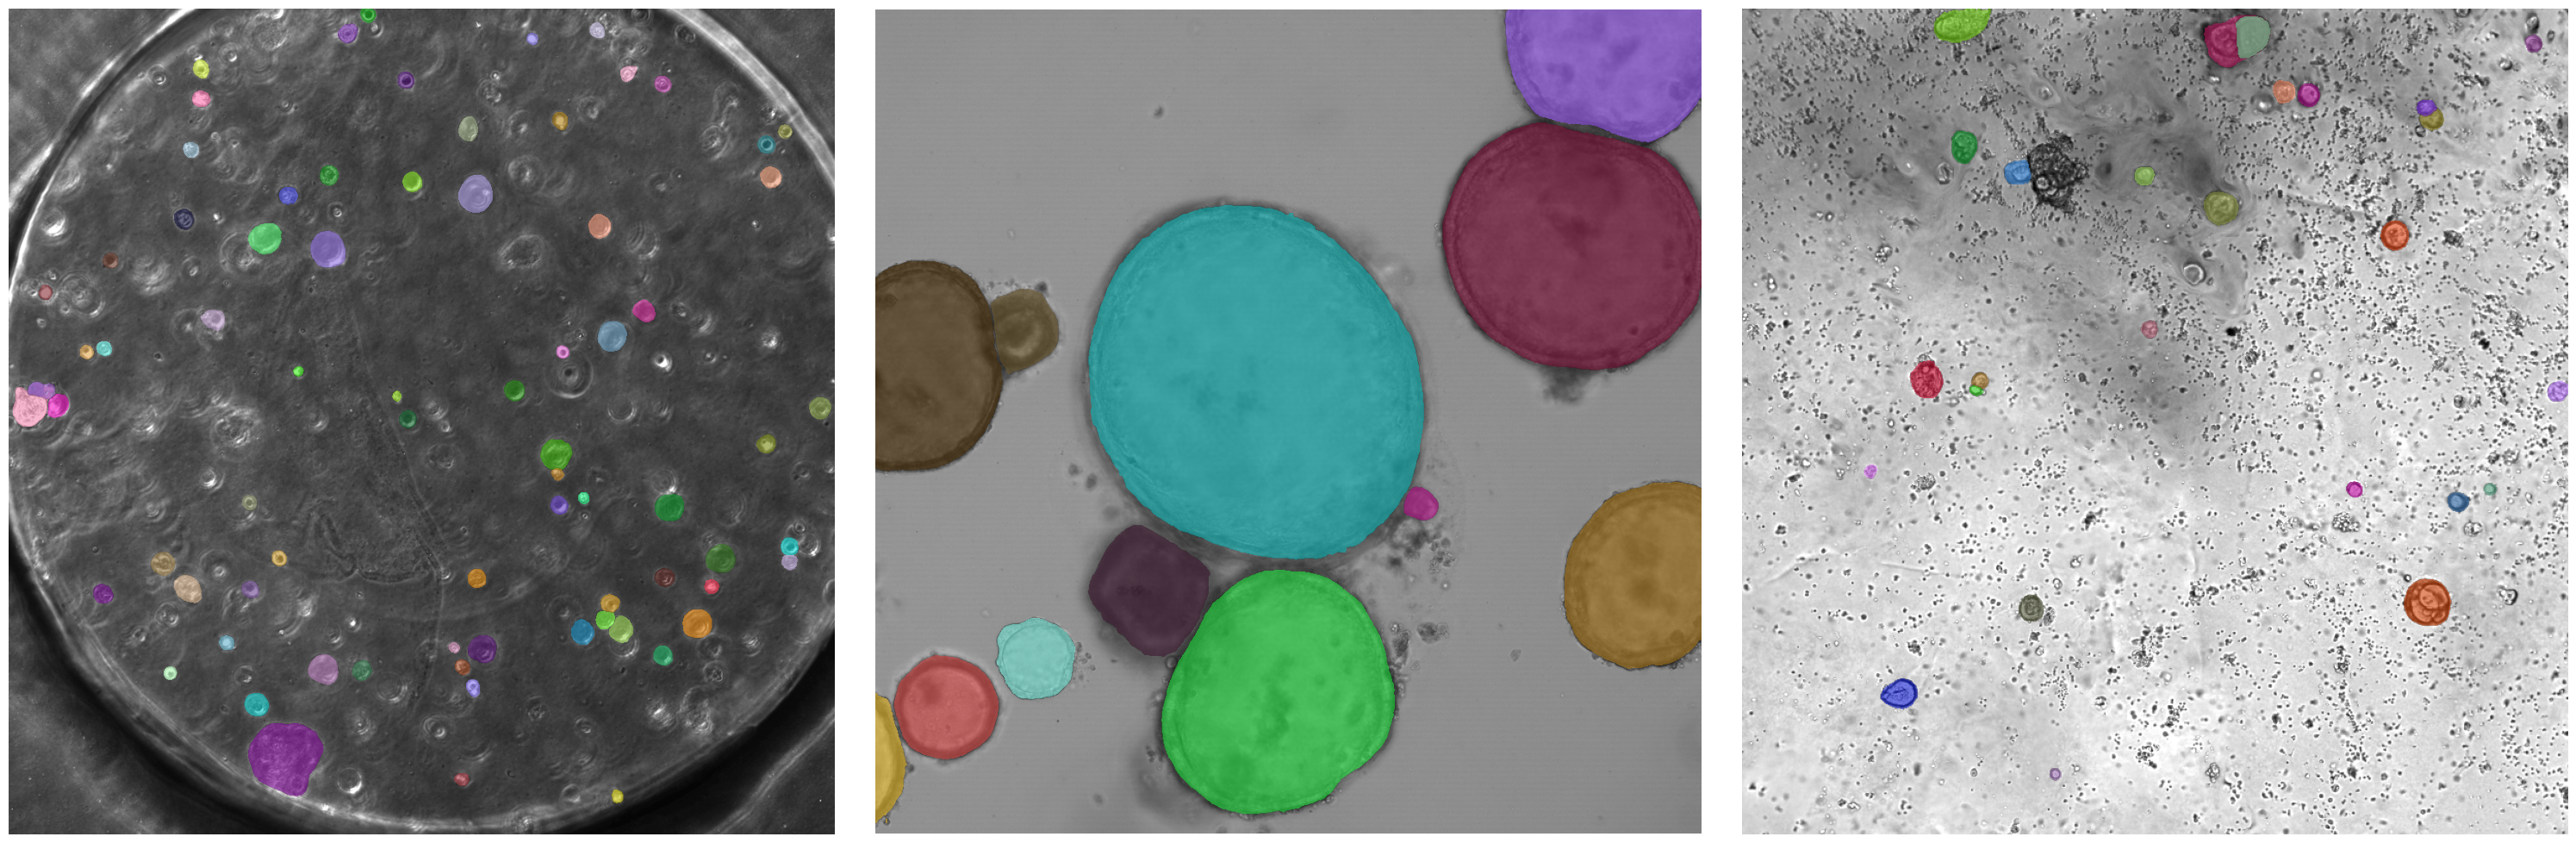

In [12]:
"""
8. Visualize segmentation mask results for the first three images:
   - Set up a matplotlib figure with a horizontal layout for three images.
   - For the first three images in out_mask:
       - Load and convert each image to RGB.
       - Display the image on its corresponding subplot.
       - Overlay all predicted masks on the image using show_mask with random colors.
       - Remove axis ticks for a cleaner look.
   - Show the combined visualization.
"""

import matplotlib.pyplot as plt
import cv2

# Create compact side-by-side display
fig, axes = plt.subplots(1, 3, figsize=(30, 10))

i = 0
for key, value in out_mask.items():
    img = cv2.imread(key)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    axes[i].imshow(img)
    for mask in out_mask.get(key):
        show_mask(mask, axes[i], random_color=True)
    
    axes[i].axis('off')
    
    i += 1
    if i == 3:
        break

plt.tight_layout()
plt.subplots_adjust(wspace=0.05)  # Adjust horizontal spacing between subplots

plt.show()

In [15]:
"""
9. Fine-tune the model:
   - Load the merged model weights from the specified file.
   - Fine-tune the model on your custom dataset using specified training parameters:
       - Set project name and training data path
       - Configure image size, epochs, batch size, optimizer, and learning rates
       - Control data augmentation and freezing of specific layers
       - Set device, number of workers, and other options
       - Allow overwriting existing runs if needed
"""

model.load('weights/orgdet_complete_merged.pt')
model.train(
    project='train_runs' + data_name,
    data=train_path,
    cache=False,
    imgsz=640,
    epochs=30,
    batch=3,
    close_mosaic=10,
    workers=0,
    device='0',
    optimizer='Adam',  # using Adam optimizer
    # resume='', # last.pt path
    #amp=True, # enable Automatic Mixed Precision
    # fraction=0.2,
    lr0=0.001,
    lrf=0.01,
    # rect=False
    #**transformations_dict,
    #cos_lr=True,
    #momentum =0.95
    freeze=[0, 1, 2, 3, 4, 5],
    #dfl=0.0,
    Distillation=None,
    loss_type=None,
    exist_ok=True
)

Transferred 1451/1459 items from pretrained weights
orgline ORGDETv0.1.0  Python-3.10.18 torch-2.3.0 CUDA:0 (NVIDIA GeForce RTX 4090, 24563MiB)
engine\trainer: task=detect, mode=train, model=orgline/cfg/models/our_model/orgline.yaml, data=data/PDAC.yaml, epochs=30, patience=200, batch=3, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=0, project=train_runsPDAC, name=train, exist_ok=True, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, step_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=[0, 1, 2, 3, 4, 5], overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=1000, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augmen

orgline.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: orgline.utils.metrics.Metric object
confusion_matrix: <orgline.utils.metrics.ConfusionMatrix object at 0x0000028356B73F70>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048,    0.049